### Kaggle datasets: Stack Overflow python questions analysis

In [61]:
from __future__ import division
from collections import Counter, defaultdict
import os
import re
import string

from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Disable pandas SettingWithCopyWarning
pd.options.mode.chained_assignment = None

work_dir = os.environ['WORK_DIR']

# Load data (Questions.csv downloaded from https://www.kaggle.com/stackoverflow/pythonquestions)
df = pd.read_csv(os.path.join(work_dir, 'Questions.csv'))
df.head()


,Id,OwnerUserId,CreationDate,Score,Title,Body
0,469,147.0,2008-08-02T15:11:16Z,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...
1,502,147.0,2008-08-02T17:01:58Z,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...
2,535,154.0,2008-08-02T18:43:54Z,40,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...
3,594,116.0,2008-08-03T01:15:08Z,25,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...
4,683,199.0,2008-08-03T13:19:16Z,28,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...


In [62]:
# Limit size

print df.size
df_frac = df.sample(frac=.001)
print df_frac.size
del df_frac['Body']

3643692
3642


In [63]:
# Clean strings - remove stopwords, punctuation, uppercase

stopwords_en = stopwords.words('english')


def remove_stopwords(row):
    if row.Title:
        return ' '.join([word for word in row.Title.split() if word not in stopwords_en])

def remove_non_letters(row):
    regex = re.compile('[^a-zA-Z]')
    if row.Title:       
        return ' '.join([regex.sub('', word) for word in row.Title.split()])

def make_lowercase(row):
    if row.Title:
        return ' '.join([word.lower() for word in row.Title.split()])

def get_bag_of_words(row):
    if row.Title:
        return Counter(row.Title.split())

df_frac['Title'] = df_frac.apply(remove_stopwords, axis=1)
df_frac['Title'] = df_frac.apply(remove_non_letters, axis=1)
df_frac['Title'] = df_frac.apply(make_lowercase, axis=1)
df_frac['TitleBagOfWords'] = df_frac.apply(get_bag_of_words, axis=1)
df_frac.dropna(subset=['Title'], inplace=True)
df_frac.head()

,Id,OwnerUserId,CreationDate,Score,Title,TitleBagOfWords
7667,1216947,59842.0,2009-08-01T16:29:27Z,1,google appenginepython can i depend task queue...,"{u'appenginepython': 1, u'google': 1, u'depend..."
329554,26914464,1766709.0,2014-11-13T17:09:31Z,0,transverse directories python,"{u'python': 1, u'directories': 1, u'transverse..."
496440,35436054,5935617.0,2016-02-16T15:09:59Z,1,what better pythonic version conditional deleting,"{u'what': 1, u'conditional': 1, u'pythonic': 1..."
99134,10342884,955487.0,2012-04-26T23:36:58Z,2,sending emails with smtplib in python,"{u'sending': 1, u'python': 1, u'in': 1, u'smtp..."
115528,11772136,1414448.0,2012-08-02T06:27:10Z,1,xmlsaxexceptionssaxparseexception tmpsudssudsh...,"{u'xmlsaxexceptionssaxparseexception': 1, u'tm..."


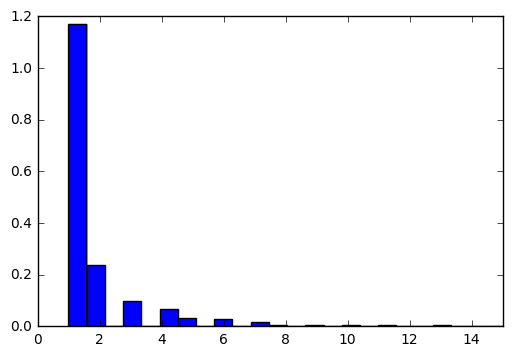

In [65]:
# Compute tf-idf

# get document frequencies
global_counter = defaultdict(int)
for title in df_frac.TitleBagOfWords:
    for word, count in title.iteritems():
        global_counter[word] += 1
        
# draw a histogram to decide on the cut off point
plt.hist(global_counter.values(), 400, normed=True)
plt.xlim(0, 15)
plt.show()

threshold = 1

global_counter_filtered = {k: v for k, v in global_counter.iteritems() if v > threshold}
        
for word, count in global_counter_filtered.iteritems():
    tag_prefix = 'Count_{}'.format(word)
    globl_tag_prefix = 'Global{}'.format(tag_prefix)
    df_frac[word] = 0
    df_frac[tag] = count

def get_title_word_count(row):
    return len(row.TitleBagOfWords.items())

def unpack_counters_to_columns(row):
    for word, count in row.TitleBagOfWords.iteritems():
        if count > threshold:
            row[word] = count
    return row

df_frac['TitleWordCount'] = df_frac.apply(get_title_word_count, axis=1)
df_frac = df_frac.apply(unpack_counters_to_columns, axis=1)
